In [1]:
from lmfit import Parameters
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
from core.util.units import compute_dft

In [4]:
def lorentzianpeak_testing2():
    """ Test the lorentzian fit directy with simulated data. """
    x_axis = np.linspace(800, 1000, 101)

    mod, params = fitlogic.make_lorentzian_model()
    print('Parameters of the model',mod.param_names)
    params = Parameters()

    params.add('amplitude',value=10.)
    params.add('center',value=920.)
    params.add('sigma',value=5)
    params.add('offset', value=10.)

    data_nice = mod.eval(x=x_axis,params=params)
    data_noisy = data_nice + 5.0*np.random.normal(size=x_axis.shape)

    result = fitlogic.make_lorentzian_fit(
        x_axis=x_axis,
        data=data_noisy,
        estimator=fitlogic.estimate_lorentzian_peak)

    plt.figure()
    plt.plot(x_axis, data_nice, label='ideal data')
    plt.plot(x_axis, data_noisy, label='noisy simulated data')
    plt.plot(x_axis, result.best_fit, '-r', label='actual fit')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

Parameters of the model ['amplitude', 'center', 'sigma', 'offset']


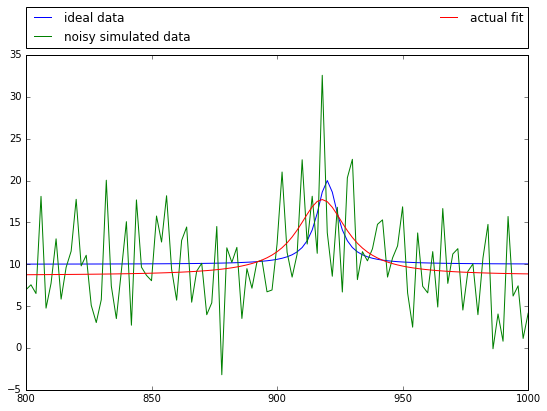

In [5]:
lorentzianpeak_testing2()

In [8]:
def lorentziandip_testing():
    """ Test the lorentzian estimator. """
    x_axis = np.linspace(800, 1000, 101)

    mod, params = fitlogic.make_lorentzian_model()
    print('Parameters of the model', mod.param_names)
    params = Parameters()

    params.add('amplitude',value=-20.)
    params.add('center',value=920.)
    params.add('sigma',value=5)
    params.add('offset', value=10.)

    data_nice = mod.eval(x=x_axis, params=params)
    data_noisy= data_nice + 6.0*np.random.normal(size=x_axis.shape)

    data_smooth, offset = fitlogic.find_offset_parameter(x_axis, data_noisy)
    print('offset',offset)

    plt.figure()
    plt.plot(x_axis, data_noisy, label='noisy data')
    plt.plot(x_axis, data_smooth, label='convoluted smooth data')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    data_level = data_smooth - offset

    amplitude = data_level.min()
    print('amplitude', amplitude)

    data_min = data_smooth.min()
    data_max = data_smooth.max()
    print('data_min', data_min)

    smoothing_spline = 1    # must be 1<= smoothing_spline <= 5
    function = InterpolatedUnivariateSpline(x_axis, data_level, k=smoothing_spline)
    numerical_integral = abs(function.integral(x_axis[0], x_axis[-1]))

    if data_max > abs(data_min):
        fitlogic.log.warning('The lorentzian estimator set the peak to the minimal value, if '
                             'you want to fit a peak instead of a dip rewrite the estimator.')

    amplitude_median = data_min
    x_zero = x_axis[np.argmin(data_smooth)]

    # For the fitting procedure it is much better to start with a larger sigma
    # then with a smaller one. A small sigma is prone to larger instabilities
    # in the fit.
    oversize_sigma = 1

    sigma = abs((numerical_integral*oversize_sigma) / (np.pi * amplitude_median))
    print('sigma', sigma)

    # auxiliary variables
    stepsize = x_axis[1]-x_axis[0]
    n_steps = len(x_axis)

    mod, params = fitlogic.make_lorentzian_model()

    params['amplitude'].set(value=amplitude, max=-1e-12)
    params['sigma'].set(value=sigma, min=stepsize/2, max=(x_axis[-1]-x_axis[0])*10)
    params['center'].set(value=x_zero, min=(x_axis[0])-n_steps*stepsize, max=(x_axis[-1])+n_steps*stepsize)
    params['offset'].set(value=offset)

    result = mod.fit(data_noisy, x=x_axis, params=params)

    print(result.fit_report())

    plt.figure()
    plt.plot(x_axis, data_nice, label='ideal data')
    plt.plot(x_axis, data_noisy, label='noisy data')
    plt.plot(x_axis, result.init_fit, '-g', label='initial fit')
    plt.plot(x_axis, result.best_fit, '-r', label='actual fit')
    plt.plot(x_axis, data_smooth, '-y', label='smoothed data')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

Parameters of the model ['amplitude', 'center', 'sigma', 'offset']
offset 9.9571642333
amplitude -10.7072796133
data_min -0.750115379988
sigma 14.259740558
[[Model]]
    ((Model(amplitude_function) * Model(physical_lorentzian)) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 68
    # data points      = 101
    # variables        = 4
    chi-square         = 3775.254
    reduced chi-square = 38.920
[[Variables]]
    fwhm:        10.9667948 +/- 4.294628 (39.16%)  == '2*sigma'
    contrast:   -149.887083 +/- 38.99848 (26.02%)  == '(amplitude/offset)*100'
    amplitude:  -16.7815360 +/- 4.250958 (25.33%) (init=-10.70728)
    center:      920.706634 +/- 1.390463 (0.15%) (init= 918)
    sigma:       5.48339741 +/- 2.147314 (39.16%) (init= 14.25974)
    offset:      11.1961188 +/- 0.739158 (6.60%) (init= 9.957164)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, sigma)          =  0.637 
    C(sigma, offset)             =  0.402 



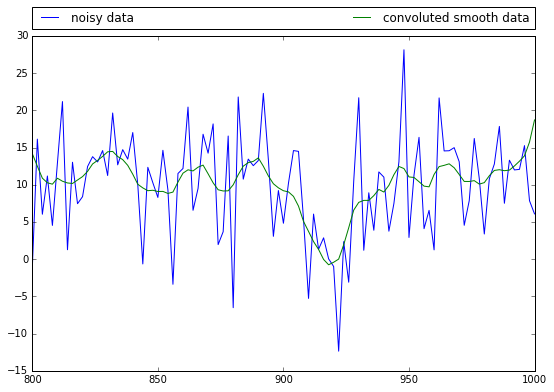

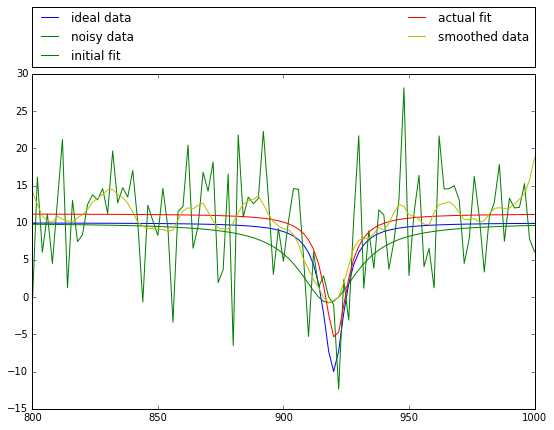

In [9]:
lorentziandip_testing()

In [6]:
def lorentziandip_testing2():
    """ Test the lorentzian fit directy with simulated data. """
    x_axis = np.linspace(800, 1000, 101)

    mod, params = fitlogic.make_lorentzian_model()
    print('Parameters of the model',mod.param_names)
    params = Parameters()

    params.add('amplitude',value=-10.)
    params.add('center',value=920.)
    params.add('sigma',value=5)
    params.add('offset', value=20.)

    data_nice = mod.eval(x=x_axis,params=params)
    data_noisy = data_nice + 2.0*np.random.normal(size=x_axis.shape)
    
    print(fitlogic.estimate_lorentzian_dip)

    result = fitlogic.make_lorentzian_fit(
        x_axis=x_axis,
        data=data_noisy,
        units=["MHz"],
        estimator=fitlogic.estimate_lorentzian_dip)

    plt.figure()
    plt.plot(x_axis, data_nice, label='ideal data')
    plt.plot(x_axis, data_noisy, label='noisy simulated data')
    plt.plot(x_axis, result.best_fit, '-r', label='actual fit')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    print(result.fit_report())
    print(result.result_str_dict)

Parameters of the model ['amplitude', 'center', 'sigma', 'offset']
<bound method estimate_lorentzian_dip of <logic.fit_logic.FitLogic object at 0x7f8062c58558>>
[[Model]]
    ((Model(amplitude_function) * Model(physical_lorentzian)) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 38
    # data points      = 101
    # variables        = 4
    chi-square         = 366.949
    reduced chi-square = 3.783
[[Variables]]
    fwhm:        8.62354950 +/- 1.970275 (22.85%)  == '2*sigma'
    contrast:   -49.9736678 +/- 7.540754 (15.09%)  == '(amplitude/offset)*100'
    amplitude:  -9.93306528 +/- 1.496476 (15.07%) (init=-6.288853)
    center:      918.925845 +/- 0.648236 (0.07%) (init= 918)
    sigma:       4.31177475 +/- 0.985137 (22.85%) (init= 4.895304)
    offset:      19.8765984 +/- 0.221925 (1.12%) (init= 19.74251)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, sigma)          =  0.655 
    C(sigma, offset)             =  0.359 

OrderedDict

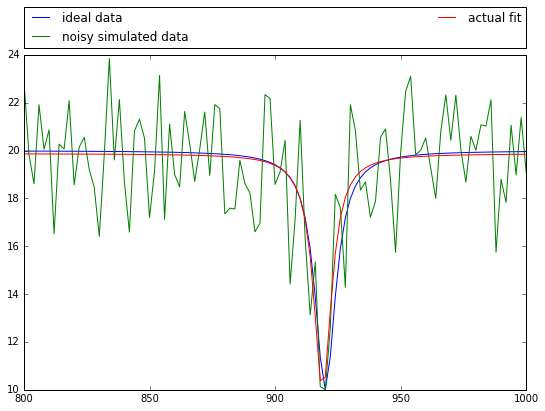

In [7]:
lorentziandip_testing2()

In [12]:
def double_lorentzpeak_testing2():
    """ Function to check the implemented double lorentz peak fit with offset. """
    start = 2800
    stop = 2950
    num_points = int((stop-start)/2)*1
    x = np.linspace(start, stop, num_points)

    x_nice = np.linspace(start, stop, num_points*4)

    mod,params = fitlogic.make_multiplelorentzian_model(no_of_functions=2)
    p=Parameters()

    #============ Create data ==========
    p.add('l0_amplitude',value=abs(np.random.random(1)*2+20))
    p.add('l0_center',value=np.random.random(1)*150.0+2800)
    p.add('l0_sigma',value=abs(np.random.random(1)*1.+1.))
    p.add('l1_center',value=np.random.random(1)*150.0+2800)
    p.add('l1_sigma',value=abs(np.random.random(1)*4.+1.))
    p.add('l1_amplitude',value=abs(np.random.random(1)*1+10))

    p.add('offset',value=100.)

    data_noisy=(mod.eval(x=x,params=p) + 6*np.random.normal(size=x.shape))

    result = fitlogic.make_lorentziandouble_fit(
        x_axis=x,
        data=data_noisy,
        estimator=fitlogic.estimate_lorentzian_peak)

    plt.figure()
    plt.plot(x, data_noisy,'o', label='noisy data')
    plt.plot(x, result.init_fit,'-y', label='initial fit')
    plt.plot(x, result.best_fit,'-r', linewidth=2.0, label='actual fit')
    plt.plot(x_nice, mod.eval(x=x_nice,params=result.params),'b',label='original')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

In [13]:
double_lorentzpeak_testing2()

Traceback (most recent call last):
  File "/home/jan/qo/qudi/logic/jupyterkernel/qzmqkernel.py", line 795, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-ecaeea535c90>", line 1, in <module>
    double_lorentzpeak_testing2()
  File "<ipython-input-12-5282405aae10>", line 28, in double_lorentzpeak_testing2
    estimator=fitlogic.estimate_lorentzian_peak)
  File "/home/jan/qo/qudi/logic/fitmethods/lorentzianlikemethods.py", line 441, in make_lorentziandouble_fit
    error, params = estimator(x_axis, data, params)
  File "/home/jan/qo/qudi/logic/fitmethods/lorentzianlikemethods.py", line 406, in estimate_lorentzian_peak
    params_dip)
  File "/home/jan/qo/qudi/logic/fitmethods/lorentzianlikemethods.py", line 374, in estimate_lorentzian_dip
    params['amplitude'].set(value=amplitude, max=-1e-12)
KeyError: 'amplitude'


In [2]:
def double_lorentzdip_testing():
    """ Test function to implement the estimator for the double lorentz dip
        fit with offset. """

    start = 2800
    stop = 2950
    num_points = int((stop-start)/2)*1
    x_axis = np.linspace(start, stop, num_points)

    x_nice = np.linspace(start, stop, num_points*4)

    mod, params = fitlogic.make_multiplelorentzian_model(no_of_functions=2)

    p=Parameters()

    #============ Create data ==========
    p.add('l0_amplitude',value=-abs(np.random.random(1)*2+20))
    p.add('l0_center',value=np.random.random(1)*150.0+2800)
    p.add('l0_sigma',value=abs(np.random.random(1)*1.+1.))
    p.add('l1_center',value=np.random.random(1)*150.0+2800)
    p.add('l1_sigma',value=abs(np.random.random(1)*4.+1.))
    p.add('l1_amplitude',value=-abs(np.random.random(1)*1+10))

    p.add('offset',value=100.)

    data_noisy = (mod.eval(x=x_axis,params=p) + 6 * np.random.normal(size=x_axis.shape))

    result = fitlogic.make_lorentziandouble_fit(
        x_axis=x_axis,
        data=data_noisy,
        estimator=fitlogic.estimate_lorentziandouble_dip)

    data_smooth, offset = fitlogic.find_offset_parameter(x_axis, data_noisy)

    data_level = data_smooth - offset

    threshold_fraction = 0.3
    minimal_threshold =  0.01
    sigma_threshold_fraction = 0.3

    ret_val = fitlogic._search_double_dip(
        x_axis,
        data_level,
        threshold_fraction,
        minimal_threshold,
        sigma_threshold_fraction)

    error = ret_val[0]
    sigma0_argleft, dip0_arg, sigma0_argright = ret_val[1:4]
    sigma1_argleft, dip1_arg , sigma1_argright = ret_val[4:7]

    if dip0_arg == dip1_arg:
        lorentz0_amplitude = data_level[dip0_arg]/2.
        lorentz1_amplitude = lorentz0_amplitude
    else:
        lorentz0_amplitude = data_level[dip0_arg]
        lorentz1_amplitude = data_level[dip1_arg]

    lorentz0_center = x_axis[dip0_arg]
    lorentz1_center = x_axis[dip1_arg]


    smoothing_spline = 1    # must be 1<= smoothing_spline <= 5
    function = InterpolatedUnivariateSpline(
        x_axis,
        data_level,
        k=smoothing_spline)
    numerical_integral_0 = function.integral(
        x_axis[sigma0_argleft],
        x_axis[sigma0_argright])

    lorentz0_sigma = abs(numerical_integral_0 / (np.pi * lorentz0_amplitude))

    numerical_integral_1 = numerical_integral_0

    lorentz1_sigma = abs(numerical_integral_1 / (np.pi * lorentz1_amplitude))

    stepsize = x_axis[1]-x_axis[0]
    full_width = x_axis[-1]-x_axis[0]
    n_steps = len(x_axis)

    mod, params = fitlogic.make_multiplelorentzian_model(no_of_functions=2)

    if lorentz0_center < lorentz1_center:
        params['l0_amplitude'].set(value=lorentz0_amplitude, max=-0.01)
        params['l0_sigma'].set(value=lorentz0_sigma, min=stepsize/2, max=full_width*4)
        params['l0_center'].set(value=lorentz0_center,
                                min=(x_axis[0])-n_steps*stepsize,
                                max=(x_axis[-1])+n_steps*stepsize)
        params['l1_amplitude'].set(value=lorentz1_amplitude, max=-0.01)
        params['l1_sigma'].set(value=lorentz1_sigma, min=stepsize/2,
                               max=full_width*4)
        params['l1_center'].set(value=lorentz1_center,
                                min=(x_axis[0])-n_steps*stepsize,
                                max=(x_axis[-1])+n_steps*stepsize)
    else:
        params['l0_amplitude'].set(value=lorentz1_amplitude, max=-0.01)
        params['l0_sigma'].set(value=lorentz1_sigma, min=stepsize/2,
                               max=full_width*4)
        params['l0_center'].set(value=lorentz1_center,
                                min=(x_axis[0])-n_steps*stepsize,
                                max=(x_axis[-1])+n_steps*stepsize)
        params['l1_amplitude'].set(value=lorentz0_amplitude, max=-0.01)
        params['l1_sigma'].set(value=lorentz0_sigma, min=stepsize/2,
                               max=full_width*4)
        params['l1_center'].set(value=lorentz0_center,
                                min=(x_axis[0])-n_steps*stepsize,
                                max=(x_axis[-1])+n_steps*stepsize)

    params['offset'].set(value=offset)

    result = mod.fit(data_noisy, x=x_axis, params=params)

    plt.figure()
    plt.plot(x_axis, data_noisy,'o', label='noisy data')
    plt.plot(x_axis, result.init_fit,'-y', label='initial fit')
    plt.plot(x_axis, result.best_fit,'-r', linewidth=2.0, label='actual fit')
    plt.plot(x_axis, data_smooth,'-g', label='smooth data')
    plt.plot(x_nice,mod.eval(x=x_nice,params=result.params),'b',label='original')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

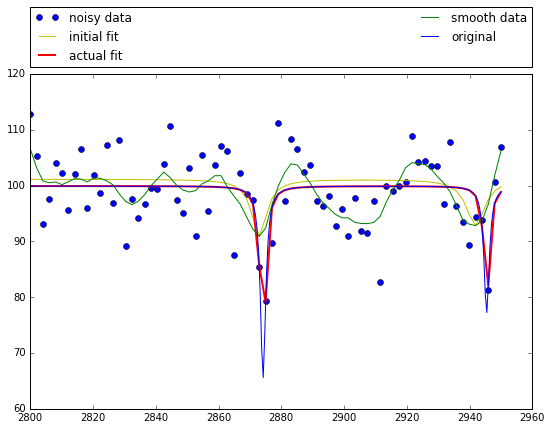

In [3]:
double_lorentzdip_testing()

In [14]:
def double_lorentzdip_testing2():
    """ Function to check the implemented double lorentz dip fit with offset. """
    start = 2800
    stop = 2950
    num_points = int((stop-start)/2)*1
    x = np.linspace(start, stop, num_points)

    x_nice = np.linspace(start, stop, num_points*4)

    mod,params = fitlogic.make_multiplelorentzian_model(no_of_functions=2)
    p = Parameters()

    #============ Create data ==========
    p.add('l0_amplitude',value=-abs(np.random.random(1)*2+20))
    p.add('l0_center',value=np.random.random(1)*150.0+2800)
    p.add('l0_sigma',value=abs(np.random.random(1)*1.+1.))
    p.add('l1_center',value=np.random.random(1)*150.0+2800)
    p.add('l1_sigma',value=abs(np.random.random(1)*4.+1.))
    p.add('l1_amplitude',value=-abs(np.random.random(1)*1+10))

    p.add('offset',value=100.)

    data_noisy=(mod.eval(x=x,params=p) + 6*np.random.normal(size=x.shape))

    result = fitlogic.make_lorentziandouble_fit(
        x_axis=x,
        data=data_noisy,
        estimator=fitlogic.estimate_lorentziandouble_dip)

    data_smooth, offset = fitlogic.find_offset_parameter(x,data_noisy)
    data_level = data_smooth - offset

    plt.figure()
    plt.plot(x, data_noisy,'o', label='noisy data')
    plt.plot(x, result.init_fit,'-y', label='initial fit')
    plt.plot(x, result.best_fit,'-r', linewidth=2.0, label='actual fit')
    plt.plot(x, data_smooth,'-g', label='smooth data')
    plt.plot(x_nice,mod.eval(x=x_nice,params=result.params),'b',label='original')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)

    plt.show()
    print(result.fit_report())


[[Model]]
    (((Model(amplitude_function, prefix='l0_') * Model(physical_lorentzian, prefix='l0_')) + Model(constant_function)) + (Model(amplitude_function, prefix='l1_') * Model(physical_lorentzian, prefix='l1_')))
[[Fit Statistics]]
    # function evals   = 168
    # data points      = 75
    # variables        = 7
    chi-square         = 2667.801
    reduced chi-square = 39.232
[[Variables]]
    l0_fwhm:        2.02702727 +/- 0.615310 (30.36%)  == '2*l0_sigma'
    l0_contrast:   -32.3518531 +/- 41.43680 (128.08%)  == '(l0_amplitude/offset)*100'
    l1_fwhm:        9.76969119 +/- 6.770970 (69.31%)  == '2*l1_sigma'
    l1_contrast:   -10.1672676 +/- 4.518023 (44.44%)  == '(l1_amplitude/offset)*100'
    l0_amplitude:  -32.6647892 +/- 41.77879 (127.90%) (init=-8.47785)
    l0_center:      2804.71256 +/- 0.592591 (0.02%) (init= 2804.054)
    l0_sigma:       1.01351363 +/- 0.307655 (30.36%) (init= 6.256704)
    offset:         100.967289 +/- 0.924995 (0.92%) (init= 101.8153)
    l1_ampl

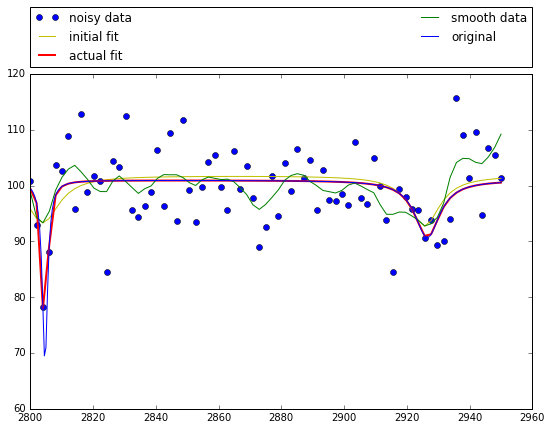

In [15]:
double_lorentzdip_testing2()

In [10]:
def double_lorentzian_fixedsplitting_testing():
    # This method does not work and has to be fixed!!!
    for ii in range(1):
        start=2800
        stop=2950
        num_points=int((stop-start)/2)
        x = np.linspace(start, stop, num_points)

        mod, params = fitlogic.make_multiplelorentzian_model(no_of_functions=2)

        p=Parameters()

        #============ Create data ==========
        p.add('c',value=100)
        p.add('lorentz0_amplitude', value=-abs(np.random.random(1)*50+100))
        p.add('lorentz0_center', value=np.random.random(1)*150.0+2800)
        p.add('lorentz0_sigma', value=abs(np.random.random(1)*2.+1.))
        p.add('lorentz1_center', value=p['lorentz0_center']+20)
        p.add('lorentz1_sigma', value=abs(np.random.random(1)*2.+1.))
        p.add('lorentz1_amplitude', value=-abs(np.random.random(1)*50+100))

        data_noisy = (mod.eval(x=x,params=p) + 2*np.random.normal(size=x.shape))

        para = Parameters()
        result = fitlogic.make_lorentziandouble_fit(
            axis=x,
            data=data_noisy,
            add_parameters=para,
            estimator=fitlogic.estimate_lorentziandouble_dip)


        data_smooth, offset = fitlogic.find_offset_parameter(x, data_noisy)
        data_level = data_smooth - offset

        #search for double lorentzian
        stuff = fitlogic._search_double_dip(x, data_level, make_prints=False)
        error, sigma0_argleft, dip0_arg, sigma0_argright, sigma1_argleft, dip1_arg , sigma1_argright = stuff
        
        print(x[sigma0_argleft], x[dip0_arg], x[sigma0_argright], x[sigma1_argleft], x[dip1_arg], x[sigma1_argright])
        print(x[dip0_arg], x[dip1_arg])

        plt.plot((x[sigma0_argleft], x[sigma0_argleft]), ( data_noisy.min() ,data_noisy.max()), 'b-')
        plt.plot((x[sigma0_argright], x[sigma0_argright]), (data_noisy.min() ,data_noisy.max()), 'b-')

        plt.plot((x[sigma1_argleft], x[sigma1_argleft]), ( data_noisy.min() ,data_noisy.max()), 'k-')
        plt.plot((x[sigma1_argright], x[sigma1_argright]), ( data_noisy.min() ,data_noisy.max()), 'k-')

        try:
            plt.plot(x,data_noisy,'o')
            plt.plot(x,result.init_fit,'-y')
            plt.plot(x,result.best_fit,'-r',linewidth=2.0,)
            plt.plot(x,data_smooth,'-g')
        except:
            print('exception')
        plt.show()

In [11]:
double_lorentzian_fixedsplitting_testing()

Traceback (most recent call last):
  File "/home/jan/qo/qudi/logic/jupyterkernel/qzmqkernel.py", line 795, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-3f98f2df8972>", line 1, in <module>
    double_lorentzian_fixedsplitting_testing()
  File "<ipython-input-10-4a1cff830865>", line 22, in double_lorentzian_fixedsplitting_testing
    data_noisy = (mod.eval(x=x,params=p) + 2*np.random.normal(size=x.shape))
  File "/usr/lib/python3/dist-packages/lmfit/model.py", line 607, in eval
    return self.op(self.left.eval(params=params, **kwargs),
  File "/usr/lib/python3/dist-packages/lmfit/model.py", line 607, in eval
    return self.op(self.left.eval(params=params, **kwargs),
  File "/usr/lib/python3/dist-packages/lmfit/model.py", line 607, in eval
    return self.op(self.left.eval(params=params, **kwargs),
  File "/usr/lib/python3/dist-packages/lmfit/model.py", line 372, in eval
    result = self.func(**self.make_funcargs(params, kwargs))
TypeError